![img](./images/Mayo_Clinic.Header.webp)

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,\
                                VotingClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix,\
                    roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

import pickle

from imblearn.pipeline import Pipeline as ImPipeline

from numpy import sqrt, argmax

import model2
from model2 import *

Pickle has been imported because models were ran in another notebook to save computing time in this notebook. 

The 'import model2' line is for a class ModelWithCV that has built in functions to run a cross validation and print accuracy, recall, precision, and f1 scores. 

All models were entered into the class in the source notebook.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning
# simplefilter("ignore", category=ConvergenceWarning)

We are ignoring Future Warnings. The version of python used in these notebooks is Python 3.8.5, the version of Sklearn is 1.0.2. Running this notebook with newer versions of either will lead to problems in regards to some methods and functions used.

### Problem Description

The Mayo Clinic has tasked us with predicting how likely individuals are to receive the seasonal flu vaccine. 
We will concentrate on:
- Predicting who will get the seasonal vaccine.
- The most significant features in determining whether or not an individual will get vaccinated?.
- How can we get more people to get vaccinated?

### Data

The data was provided by DrivenData as a part of their competition. Details about the competition and getting the data can be found https://www.drivendata.org/competitions/66/flu-shot-learning/

The data was provided in two separate files, which were combined for cleaning, splitting again later. 

In [3]:
training_set_features = pd.read_csv('./Data/training_set_features.csv')
training_set_labels = pd.read_csv('./Data/training_set_labels.csv')
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [4]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

There are a considerable number of NA values in the dataset.

If the employment_status column has a value of Not in Labor Force, then columns employment_industry and employment_occupation will have NA's. 

Values in columns employment_industry and employment_occupation are represented as short random character strings. 

We will be filling NA's in employment_occupation and employment_industry associated with "Not in Labor Force" with because they would otherwise be imputed as the most frequent occupation or industry.

Filling Unemployed with "Not in Labor Force".

In [5]:
complete_data['employment_status'].replace("Unemployed", "Not in Labor Force", inplace=True)
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

In [6]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_occupation     1786
employment_industry       1646
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [7]:
complete_data['health_insurance'].isna().sum()

12274

In [8]:
complete_data['health_insurance'].fillna('Unknown', inplace=True)
complete_data['health_insurance'].replace(0.0,'0', inplace=True)
complete_data['health_insurance'].replace(1.0,'1', inplace=True)

With the substantial number of NA's in Health Insurance we have decided to create a new category of "Unknowns". Replaced float values of 1.0 and 0.0 with string values. 

#### Target Distribution

In [9]:
complete_data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [10]:
Vax_dist = complete_data['seasonal_vaccine'].value_counts(normalize=True).mul(100).round(1)

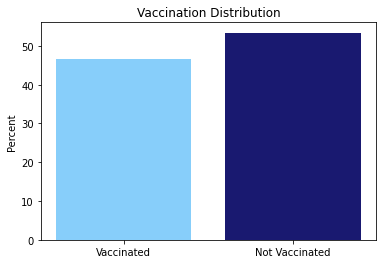

In [11]:
fig, ax = plt.subplots()
bar1 = plt.bar(0, Vax_dist[1], color='lightskyblue', label='Unvaxinated')
bar2 = plt.bar(1, Vax_dist[0], color='midnightblue', label='Unvaxinated')
ax.set_xticks([0,1])
ax.set_xticklabels(['Vaccinated', 'Not Vaccinated'])
ax.set_ylabel('Percent')
ax.set_title('Vaccination Distribution')
plt.savefig('./images/Vaccination_Distribution.jpeg', bbox_inches = 'tight')
plt.savefig('./images/Vaccination_Distribution.png', bbox_inches = 'tight')

Our target variable is distributed quite evenly. 47:53.

### Split

Here we separated out our target variable 'seasonal_vaccine' and dropped 'respondent_id' and 'h1n1_vaccine'.

The 'values.ravel()' method reshapes y_train into a 1-D array.

In [12]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y = complete_data.filter(['seasonal_vaccine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = y_train.values.ravel()

### Pipelines for Column Transformer

All columns are in a categorical format, however, some are scales and may better be represented as numeric columns.

Numeric columns include h1n1_concern, h1n1_knowledge, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, and opinion_seas_sick_from_vacc.

In [13]:
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',\
            'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',\
            'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
cat_cols = X.columns.drop(num_cols)

In [14]:
X[num_cols].describe()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
count,26615.000000,26591.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000
mean,1.618486,1.262532,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112
std,0.910311,0.618149,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000
50%,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
75%,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [15]:
X[num_cols].median()

h1n1_concern                   2.0
h1n1_knowledge                 1.0
opinion_h1n1_vacc_effective    4.0
opinion_h1n1_risk              2.0
opinion_h1n1_sick_from_vacc    2.0
opinion_seas_vacc_effective    4.0
opinion_seas_risk              2.0
opinion_seas_sick_from_vacc    2.0
dtype: float64

Because there are some missing values in the numeric columns, it is important determine the best measure of central tendency to replace these values. Because the values are scaler in nature we have decided to use the 'median' of each column to fill in these values.  

For categorical variables, the most frequent value for each column will be used to fill in the missing values.

In [16]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')) ])

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                              ('ss', StandardScaler()) ])

In [17]:
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_num', subpipe_num, num_cols)
])

### Models

Now that our Column Transformer pipeline has been created we can start running models. 
- First Models were executed with their default parameters. 
- Then they were run through a GridSearchCV to find the best parameter combos. To save time, no more than a few parameters were chosen to be tuned for each model. Because of our business problem, only models with the feature_importances_ attribute were picked.
- After tuning these models they were entered into ensembles as VotingClassifiers. In the end a VotingClassifier with just two estimators, Random Forest and Extra Trees, performed just as well as a VotingClassifier with five estimators. Due to the difference in computation time the simpler model was selected as the final model. 

Below you will see the process and results for the estimators and the final model selected. You can find the process and results for all other models in the source notebook.

#### Dummy Classifier

All models were executed in the following format. 

In [18]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(random_state=42))
])

In [19]:
dummy_model_pipe.fit(X_train, y_train);

In [20]:
dummy_pipe = ModelWithCV(dummy_model_pipe, model_name='dummy_pipe', X=X_train, y=y_train) 

In [21]:
dummy_pipe.print_cv_summary() 

CV Results for `dummy_pipe` model:
            0.53105 ± 0.00015 accuracy
            recall_score: 0.0
            precision_score: 0.46895434857961904
            f1_score: 0.0    
        


The 'print_cv_summary' function comes from the ModelWithCV class where the model runs a 10 fold cross validation to return accuracy, recall, precision, and f1 scores.

Our dummy classifier predicts the most common value for the target value. It's accuracy is at about 53%, which is to be expected given the target distribution.

#### Random Forest

The first Estimator to be run was SkLearn's Random Forest Classifier. 

In [22]:
import pickle
with open('forest.sav', 'rb') as f:
    forest = pickle.load(f)

In [23]:
forest.print_cv_summary()

CV Results for `forest_pipe` model:
            0.77153 ± 0.01219 accuracy
            recall_score: 0.7391263692604574
            precision_score: 0.8263930425720363
            f1_score: 0.7521140408449998    
        


The Random Forest Classifier performed considerably better than the Dummy Classifier Model.

##### Random Forest  Tuned

Our Grid Search determined the optimal parameters for Random Forest was max_features= 'sqrt' and n_estimators= 1250.

In [24]:
import pickle
with open('tuned_forest.sav', 'rb') as f:
    tforest = pickle.load(f)

In [25]:
tforest.print_cv_summary() 

CV Results for `tforest_pipe` model:
            0.77706 ± 0.01164 accuracy
            recall_score: 0.7499721891140246
            precision_score: 0.8336055852918713
            f1_score: 0.759324132932402    
        


The Tuned Random Forest Classifier does perform slightly better on each scoring metric. However, we are concentrated primarily on accuracy scores. 

#### Extra Trees Classifier

The next Estimator is SkLearn's Extra Trees Classifier.

In [26]:
import pickle
with open('etc.sav', 'rb') as f:
    etc = pickle.load(f)

In [27]:
etc.print_cv_summary() 

CV Results for `etc_pipe` model:
            0.77058 ± 0.01184 accuracy
            recall_score: 0.733285941313355
            precision_score: 0.8226913437164194
            f1_score: 0.7498575863366292    
        


Again this classifier perform substantially better than the Dummy Classifier and just about as well as the Random Forest Classifier.

#####  Extra Trees Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was max_depth = 50 and n_estimators = 500.

In [28]:
import pickle
with open('tuned_etc.sav', 'rb') as f:
    tuned_etc = pickle.load(f)

In [29]:
tuned_etc.print_cv_summary() 

CV Results for `tetc_pipe` model:
            0.77399 ± 0.01175 accuracy
            recall_score: 0.740079743458766
            precision_score: 0.8302410092727717
            f1_score: 0.7543782442015724    
        


The Tuned Extra Trees Classifier does perform slightly better on each scoring metric. But again we are concentrated primarily on accuracy scores. 

### Ensembled

The tuned Random Forest model and tuned Extra Trees model were entered into a Voting Classifier. Below the results of that Voting Classifier.

In [30]:
with open('avg2_model.sav', 'rb') as f:
    avg2_model = pickle.load(f)

In [31]:
avg2_model.print_cv_summary()

CV Results for `avg2_pipe` model:
            0.77718 ± 0.01159 accuracy
            recall_score: 0.7463972132357114
            precision_score: 0.8337415272006232
            f1_score: 0.7585331782501775    
        


The Voting Classifier does slightly better than both of it's estimators did individually. It may be beneficial to tune again.

### Feature Importance

For our business problem it was necessary to extract the most important features. 
- First we extract the One Hot Encoded column names (ohe_cat_cols)
- The because the numeric columns were after the One Hot Encoding we add the list of numeric column names (num_cols) to the list of One Hot Encoded columns (ohe_cat_cols) to get the column names after the Column Transformer has been executed (post_ct_cols)

In [32]:
avg2_fit = avg2_model.model.fit(X_train, y_train); #22s

In [33]:
ohe_col_names = avg2_model.model.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names_out()

ohe_cat_cols = ohe_col_names.tolist()

In [34]:
post_ct_cols = ohe_cat_cols + num_cols

Next we make a Data Frame using the array that is created after the Column Transformer and name the columns from the list created above.

In [35]:
X_post = pd.DataFrame(avg2_model.model.named_steps['ct'].fit_transform(X_train, y_train), columns=post_ct_cols)

In [36]:
X_post

,x0_1.0,x1_1.0,x2_1.0,x3_1.0,x4_1.0,x5_1.0,x6_1.0,x7_1.0,x8_1.0,x9_1.0,...,x26_xtkaffoo,x26_xzmlyyjv,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,-0.686593,1.197462,0.147289,-0.270422,-0.265923,-0.030392,0.934322,-0.089462
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.516834,1.197462,0.147289,1.291698,-1.002707,0.903974,1.660931,-0.845239
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.516834,1.197462,0.147289,-1.051483,-1.002707,0.903974,0.934322,-0.845239
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.686593,1.197462,1.147458,1.291698,-0.265923,0.903974,-0.518896,-0.089462
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,-0.686593,1.197462,0.147289,1.291698,-0.265923,-0.030392,0.934322,-0.089462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17888,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.415121,-0.425980,0.147289,-0.270422,-0.265923,-0.030392,-0.518896,-0.845239
17889,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.686593,-0.425980,0.147289,-0.270422,-1.002707,-0.030392,-0.518896,1.422094
17890,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.415121,-0.425980,0.147289,-0.270422,-0.265923,-0.030392,-0.518896,-0.089462
17891,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.415121,-0.425980,-2.853217,-1.051483,1.207646,-2.833489,-1.245505,1.422094


Next this for loop creates a dictionary with the an array of feature importance for each estimator. 

We then get the average feature importance by adding the arrays together and dividing them by two.

In [37]:
feat_imp = {}
for est in avg2_model.model.named_steps['avg2'].named_estimators:
    etc = avg2_model.model.named_steps['avg2'].named_estimators[est]
    feat_imp[etc] = etc.fit(X_post, y_train).feature_importances_ #22s

In [38]:
avg_feat_imp = (list(feat_imp.values())[0] + list(feat_imp.values())[1])/2

And finally, we create a Data Frame with the columns representing the Features and their Importances. We then sort values by Feature Importance and create a new Data Frame with just the top ten feature importances, clean the value names up a bit and make a bar chart for visual purposes. 

In [39]:
df = pd.DataFrame()
df['Features'] = post_ct_cols
df['Feature_importance'] = avg_feat_imp
top_ten_feat = df.sort_values('Feature_importance', ascending=False).head(10)

In [40]:
top_ten_feat.Features = [row.strip().lower().replace('_',' ') for row in top_ten_feat.Features]
top_ten_feat['Features'].replace('x8 1.0', 'Doctor Recommended', inplace=True)

In [41]:
top_ten_feat

,Features,Feature_importance
97,opinion seas risk,0.077815
96,opinion seas vacc effective,0.075493
8,Doctor Recommended,0.068744
17,x13 65+ years,0.036875
94,opinion h1n1 risk,0.032015
93,opinion h1n1 vacc effective,0.029749
98,opinion seas sick from vacc,0.026720
91,h1n1 concern,0.025773
95,opinion h1n1 sick from vacc,0.024122
92,h1n1 knowledge,0.021408


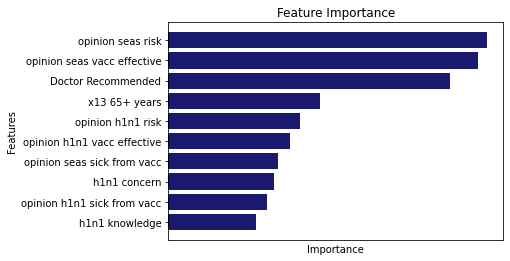

In [42]:
fig, ax = plt.subplots()
ax.barh(y= top_ten_feat.Features, width= top_ten_feat['Feature_importance'], color='midnightblue')
ax.set_title('Feature Importance')
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
plt.xticks([])
ax.invert_yaxis()
plt.savefig('./images/Feature_Importance.jpeg', bbox_inches = 'tight');
plt.savefig('./images/Feature_Importance.png', bbox_inches = 'tight');

The top 3 most important features in determining whether a person was to get vaccinated are 
- A person's opinion on the risk of the seasonal flu 
- If it was Doctor Recommended
- An opinion on seasonal vaccine effectiveness

### Final Model

Now we will take a look at our final model's performance.

In [43]:
final_model = avg2_fit

In [44]:
#final_model.fit(X_train, y_train); 

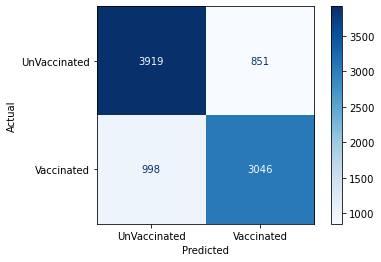

In [45]:
fm_cm = plot_confusion_matrix(final_model, X_test, y_test, cmap="Blues",\
                              display_labels=['UnVaccinated','Vaccinated'])
fm_cm.ax_.set(xlabel='Predicted', ylabel='Actual')

plt.savefig('./images/Confusion.jpeg', bbox_inches = 'tight');

The confusion matrix above shows the counts of our predicted target variable against the actual target variable counts. Our true positive counts and true negative counts are much more dense then our false positives and false negatives. 

In [46]:
y_hat = final_model.predict(X_test) 

In [47]:
accuracy_score, recall_score, precision_score, f1_score

(<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>,
 <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [48]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.75 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



When we apply

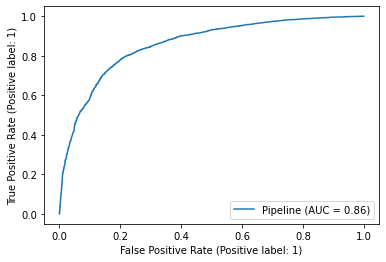

In [49]:
fm1_roc_curve = plot_roc_curve(final_model, X_test, y_test)
plt.savefig('./images/ROC_Curve.jpeg', bbox_inches = 'tight');

Let's take it one step further and choose a specific threshold to optimize our scores. The code to calculate on optimal threshold was provided by https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/.

In [50]:
y_hat = final_model.predict_proba(X_test)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.471400, G-Mean=0.791


In [51]:
y_hat = (final_model.predict_proba(X_test)[:,1] >= thresholds[ix]).astype(bool) 

In [52]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.79 

Our final model's precision on the test set is 0.76 

Our final model's f1-score on the test is 0.78.



In [53]:
cm = confusion_matrix(y_test, y_hat)

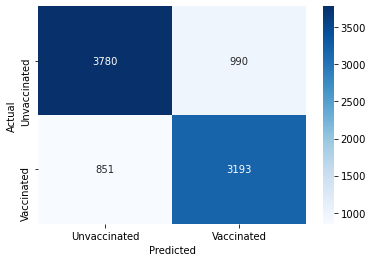

In [54]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels= ['Unvaccinated', 'Vaccinated'],
            yticklabels= ['Unvaccinated', 'Vaccinated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./images/Confusion2.jpeg', bbox_inches = 'tight');

By choosing a specific threshold we were able to reduce the number of false negatives at the expense of false positives. This isn't really useful in our case, but it may be useful if we receive new data. In addition this may be helpful if we want to concentrate specifically on identifying Vaccinated individuals over UnVaccinated individuals.

In [55]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

In [56]:
100*(TP/ (TP+FP))

76.33277551996174

In [57]:
100*(TN/ (TN+FN))

81.62383934355431

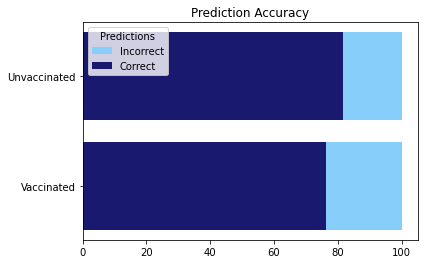

In [58]:
b2 = plt.barh(['Vaccinated', 'Unvaccinated'], 
              [100*(TP/ (TP+FP)), 100*(TN/ (TN+FN))],
              color="midnightblue")

b1 = plt.barh(['Vaccinated', 'Unvaccinated'], 
              [100*(FP/ (TP+FP)),100*(FN/ (TN+FN))], 
              left=[100*(TP/ (TP+FP)), 100*(TN/ (TN+FN))], 
              color="lightskyblue")

plt.legend([b1, b2], ["Incorrect", "Correct"], 
           title="Predictions", loc="best")
plt.title('Prediction Accuracy')

plt.savefig('./images/Prediction_Accuracy.jpeg', bbox_inches = 'tight')
plt.savefig('./images/Prediction_Accuracy.png', bbox_inches = 'tight')
plt.show();

Because we are using an older version of SkLearn we have to plot our ROC Curve by hand. The following code block was also found on https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/. Newer versions of SkLearn take predicted y and actual y values as arguments rather than the model and y values. 

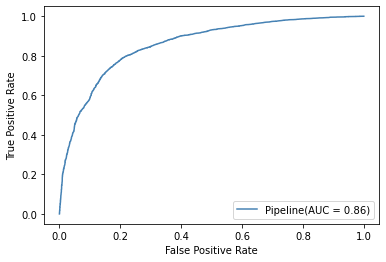

<Figure size 432x288 with 0 Axes>

In [59]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
final_model.fit_transform(X_train, y_train)
# predict probabilities
lr_probs = final_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = round((roc_auc_score(y_test, lr_probs)), 2)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, label=f'Pipeline(AUC = {lr_auc})', color='steelblue')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()
plt.savefig('./images/ROC_Curve2.jpeg', bbox_inches = 'tight');

Choosing our classification threshold here doesn't improve our model's metrics significantly, however, it could prove essential in a data set where the target variable is more imbalanced.

### Next Steps

Possible Room for Improvement:
- With more time we could run and tune more models. More and better models could improve our model's performance. 
- Tuning again after combining the estimators may also prove beneficial. 
- Getting another data source may add to the robustness of our models.
- We may be able to predict other target variables